In [1]:
#!/usr/bin/env python
# import analyzer
import importlib
from importlib import reload
import os, sys, glob, warnings, glob
import numpy as np
import scipy as sp
import joblib
# from tqdm.notebook import tqdm
from tqdm import tqdm
import ROOT as root
from pylab import *

import iminuit
from iminuit import Minuit, cost

import matplotlib.pyplot as plt
from matplotlib import collections, colors, transforms
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %matplotlib widget

Welcome to JupyROOT 6.24/06


In [2]:
# modules in this directory
import visualization, util, event, cutflow, detector, Kalman_tom
import visualization as vis
import cutflow,detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(Kalman_tom)

<module 'Kalman_tom' from '/project/6035200/tomren/jupyter/tracker_analysis/Kalman_tom.py'>


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



# Fit methods comparison

1. LS fit, with (x0,t0,z0,vx,vy,vz) as parameters
2. Kalman filter, with (vx,vy,vz) as parameters, Q=0
3. Kalman filter, with (x0,t0,z0,vx,vy,vz) as parameters, Q=0
4. Kalman filter, with (vx,vy,vz) as parameters, Q from multiple scattering (**Current MATHUSLA implementation**)
5. Kalman filter, with (x0,t0,z0,vx,vy,vz) as parameters, Q from multiple scattering

1 and 4 should be equal mathmatically

In [3]:
# Tree=ev.Tree
# barnches = Tree.GetListOfBranches()
# nevents = int(Tree.GetEntries())
# branch_list = [barnches[i].GetName() for i in range(len(barnches))]
# print(branch_list)

In [4]:
import lsfit
reload(lsfit)
from lsfit import *

import include_modules_root as rt
import Kalman_tom

In [5]:
# Data preparation:
# get all tracks that have 7 hits (one hit per layer)


def gen_hits(Vx=2,Vy=25,Vz=3,x0=450,z0=450+11950,t0=6):
    Y_LAYERS = np.array([0,1, 5,6,7,8,9])*100 #cm
    unc_low = 0.04/np.sqrt(12)*100 #cm
    unc_high = 1*sp.constants.c/1e7/np.sqrt(2)/1.5 #cm
    UNC_X = [unc_low,unc_high,unc_low,unc_high,unc_low,unc_high,unc_low]
    UNC_Z = [unc_high,unc_low,unc_high,unc_low,unc_high,unc_low,unc_high]
    unc_low2=unc_low
    UNC_X_multi = [unc_low2,unc_high,unc_low2,unc_high,unc_low2,unc_high,unc_low2]
    UNC_Z_multi = [unc_high,unc_low2,unc_high,unc_low2,unc_high,unc_low2,unc_high]    
    UNC_T = 1 #ns
    UNC_Y = 2/np.sqrt(12) #uncertainty in thickness, cm
    
    det_width=4.5 # 4.5cm per bar

    hits=[]
    hits_truth=[]
    hits_err=[]
    for i in range(len(Y_LAYERS)):
        t=(Y_LAYERS[i]-Y_LAYERS[0])/Vy
        hits_truth.append([x0+Vx*t,Y_LAYERS[i], z0+Vz*t, t+t0])
        if UNC_X[i]==unc_low:
            hits.append(Hit((x0+Vx*t)//det_width*det_width,
                            Y_LAYERS[i],
                            z0+Vz*t+np.random.normal(0,1)*UNC_Z_multi[i],
                            t+t0+np.random.normal(0,UNC_T)))
        else:
            hits.append(Hit(x0+Vx*t+np.random.normal(0,1)*UNC_X_multi[i],
                            Y_LAYERS[i],
                            (z0+Vz*t)//det_width*det_width,
                            t+t0+np.random.normal(0,UNC_T)))            
            
        hits[-1].x_uncertainty=UNC_X[i]
        hits[-1].z_uncertainty=UNC_Z[i]
        hits[-1].y_uncertainty=UNC_Y
        hits_err.append([UNC_X[i],UNC_Y,UNC_Z[i],UNC_T])
        
    par_truth = [x0,t0,z0,Vx,Vy,Vz]
        
    return np.array(hits),np.array(hits_err),np.array(hits_truth),np.array(par_truth)

In [6]:
# Generated toy hits

N_events=5000
Hit_collection={}
Truth_collection ={}
ParTruth_collection={}
for i in range(N_events):
    Hit_collection[i],_,Truth_collection[i],ParTruth_collection[i]=gen_hits()

Text(0, 0.5, 'z [cm]')

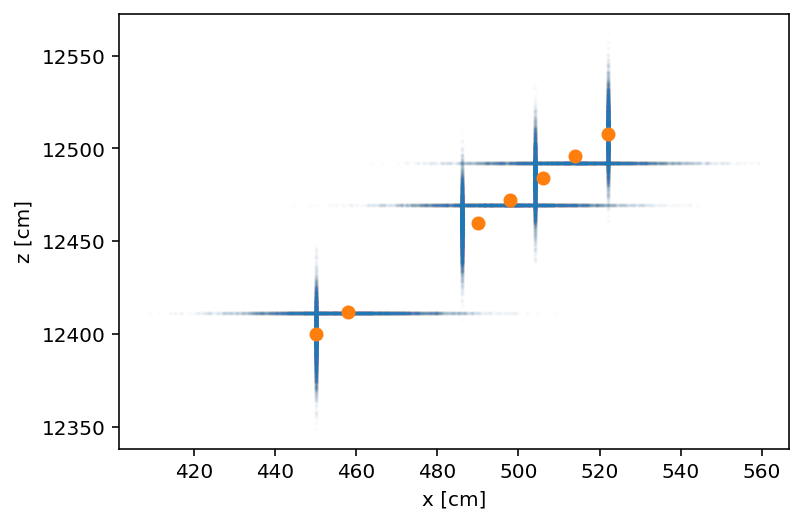

In [7]:
xs=[]
zs=[]
for ihits in Hit_collection:
    for hit in Hit_collection[ihits]:
        xs.append(hit.x)
        zs.append(hit.z)
scatter(xs,zs, s=1,alpha=0.01)
for hit in Truth_collection[0]:
    scatter(hit[0],hit[2],color="C1")
xlabel("x [cm]")
ylabel("z [cm]")

## 1. Define LS fit

In [8]:
# -------------------------------------
# LS fit
# ------------------------------------
class chi2_track:
    def __init__(self, hits):
        self.hits=hits
        self.func_code = iminuit.util.make_func_code(['x0', 'y0', 'z0', 't0', 'vx', 'vy', 'vz'])
    def __call__(self, x0, y0, z0, t0, vx, vy, vz):
        error=0
        for hit in self.hits:
            model_t = (hit.y - y0)/vy
            model_x = x0 + model_t*vx
            model_z = z0 + model_t*vz
            error+= np.sum(np.power([(model_t- (hit.t-t0))/hit.t_uncertainty, 
                                     (model_x-hit.x)/hit.x_uncertainty, 
                                     (model_z-hit.z)/hit.z_uncertainty],2))
        return error        

def guess_track(hits):
    # Guess initial value
    x0_init = hits[0].x
    y0_init = hits[0].y
    z0_init = hits[0].z
    t0_init = hits[0].t
    dt=hits[-1].t-hits[0].t
    vx_init = (hits[-1].x-hits[0].x)/dt
    vy_init = (hits[-1].y-hits[0].y)/dt
    vz_init = (hits[-1].z-hits[0].z)/dt
    v_mod = np.sqrt(vx_init**2+vy_init**2+vz_init**2)
    if v_mod>sp.constants.c*1e-7:
        vx_init = vx_init*0.99*sp.constants.c*1e-7/v_mod
        vy_init = vy_init*0.99*sp.constants.c*1e-7/v_mod
        vz_init = vz_init*0.99*sp.constants.c*1e-7/v_mod
    return  (x0_init,y0_init, z0_init,t0_init,vx_init,vy_init,vz_init)
    
def fit_track(hits, guess):
    x0_init,y0_init, z0_init,t0_init,vx_init,vy_init,vz_init = guess
    det=detector.Detector()

    m = Minuit(chi2_track(hits),x0=x0_init, y0=y0_init, z0=z0_init, t0=t0_init, vx=vx_init, vy=vy_init, vz=vz_init)
    m.fixed["y0"]=True
    m.limits["x0"]=(det.BoxLimits[0][0],det.BoxLimits[0][1])
    m.limits["z0"]=(det.BoxLimits[2][0],det.BoxLimits[2][1])
    m.limits["t0"]=(-100,1e5)
    m.limits["vx"]=(-sp.constants.c*1e-7, sp.constants.c*1e-7) # Other
    m.limits["vy"]=(-sp.constants.c*1e-7*2,0) if vy_init<0 else (0,sp.constants.c*1e-7*2) # Constrain the direction in Z(up) in real world
    m.limits["vz"]=(-sp.constants.c*1e-7, sp.constants.c*1e-7) # Beam direction; From MKS unit to cm/ns = 1e2/1e9=1e-7
    m.errors["x0"]=0.1
    m.errors["y0"]=0.1
    m.errors["z0"]=0.1
    m.errors["t0"]=0.3
    m.errors["vx"] = 0.01
    m.errors["vy"] = 0.1
    m.errors["vz"] = 0.01

    m.migrad()  # run optimiser
    m.hesse()   # run covariance estimator
    
    return m

## Define Kalman filter, 3 parameters, Q=3

# Let's fix the definition of F!

In [108]:
# ----------------------------------------------------------------------
def Seed(hits):
#     c=sp.constants.c/1e7
    c=29.97
    seeds=[]
    for i in range(len(hits)):
        for j in range(i+1, len(hits)):
            dx = hits[i].x- hits[j].x
            dy = hits[i].y- hits[j].y
            dz = hits[i].z- hits[j].z
            dt = hits[i].t- hits[j].t
            ds = np.abs((dx**2+dy**2-dz**2)/c**2-dt**2)
#             print(i,j, ds)
#             print(hits[i].x, hits[i].z,hits[j].x, hits[j].z)
            if ds>5:
                continue
                
#             seeds.append([hits[i],hits[j]])
            seeds.append([i,j,ds])
    return np.array(seeds)

def init_state(hits):
#     score = Seed(hits)
#     ind=np.argmin(score[:,2])
# #     ind=0
#     i=int(score[ind][0])
#     j=int(score[ind][1])
# #     print(i,j)
    i=0
    j=-1
    
    dt=hits[j].t-hits[i].t
    dx=hits[j].x-hits[i].x
    dy=hits[j].y-hits[i].y
    dz=hits[j].z-hits[i].z
    
#     print(dx,dy,dz,dt)
    
    # Initial State Vector: X0
    X0 = np.array([hits[0].x, hits[0].t, hits[0].z, dx/dt, dy/dt, dz/dt])
#     X0 = np.array([hits[1].x, hits[1].t, hits[1].z, dx/dt, dy/dt, dz/dt])
    
    # Initial Variance P0
    J =np.array([[ 1      , 0           , 0       , 0       , 0       , 0             , 0     , 0     ],
        [ 0       , 1           , 0       , 0       , 0       , 0             , 0     , 0     ],
        [ 0       , 0           , 1       , 0       , 0       , 0             , 0     , 0     ],
        [- 1 / dt, dx / (dt*dt), 0       , 0       , 1 / dt  , - dx / (dt*dt), 0     , 0     ],
        [0       , dy / (dt*dt), 0       , - 1 / dt, 0       , - dy / (dt*dt), 0     , 1 / dt],
        [0       , dz / (dt*dt), - 1 / dt, 0       , 0       , - dz / (dt*dt), 1 / dt, 0     ]])
#     # Initial Variance P0
#     J =np.array([[ 0      , 0           , 0       , 0       , 1       , 0             , 0     , 0     ],
#                 [ 0       , 0           , 0       , 0       , 0       , 1             , 0     , 0     ],
#                 [ 0       , 0           , 0       , 0       , 0       , 0             , 1     , 0     ],
#                 [- 1 / dt, dx / (dt*dt), 0       , 0       , 1 / dt  , - dx / (dt*dt), 0     , 0     ],
#                 [0       , dy / (dt*dt), 0       , - 1 / dt, 0       , - dy / (dt*dt), 0     , 1 / dt],
#                 [0       , dz / (dt*dt), - 1 / dt, 0       , 0       , - dz / (dt*dt), 1 / dt, 0     ]])
    err0=np.diag([hits[i].x_uncertainty,hits[i].t_uncertainty,hits[i].z_uncertainty,hits[i].y_uncertainty,
                 hits[j].x_uncertainty,hits[j].t_uncertainty,hits[j].z_uncertainty,hits[j].y_uncertainty])**2
    P0=J.dot(err0).dot(J.T)
    
#     P0=np.diag(np.ones(6)*1e10)
    
    return X0, P0

def init_state_LS(hits,x0,x0_cov):
    # Initial State Vector: X0
    X0 = np.array([x0[0], x0[2], x0[2], x0[3], x0[4], x0[5]])
    P0=x0_cov
    return X0, P0

def f_model(x,t,z,vx,vy,vz, dy):
    xn = x + dy*vx/vy
    tn = t + dy* 1/vy
    zn = z + dy*vz/vy
    return (xn, tn, zn, vx, vy, vz)


def add_measurement(hit, X_current, dy):
    vy_current = X_current[4]
    dt_next = dy/vy_current
    Y = np.array([hit.x,hit.t,hit.z])
    R = np.diag([hit.x_uncertainty,hit.t_uncertainty,hit.z_uncertainty])**2
    A = np.array([[1, 0, 0, dt_next, 0, 0],
                  [0, 1, 0, 0, dt_next/vy_current, 0],
                  [0, 0, 1, 0, 0, dt_next],
                  [0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 1]])
    return  Y,R,A

def add_measurement_corrected(hit, X_current, dy):
    """
    Change the definition of A to the jacobian of f
    return f as well
    """
    vx_current = X_current[3]
    vy_current = X_current[4]
    vz_current = X_current[5]
    dt_next = dy/vy_current
    Y = np.array([hit.x,hit.t,hit.z])
    R = np.diag([hit.x_uncertainty,hit.t_uncertainty,hit.z_uncertainty])**2
    A = np.array([[1, 0, 0, dt_next, -dy*vx_current/vy_current**2, 0],
                  [0, 1, 0, 0, -dt_next/vy_current, 0],
                  [0, 0, 1, 0, -dy*vz_current/vy_current**2, dt_next],
                  [0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 1]])
    f = lambda state: f_model(*state, dy)
    return  Y,R,A, f


def fit_kf_1(hits, init_truth=None,X0=None,P0=None):
    # Initial state (X0), covariance (P0), measurement (X0)
    if X0 is None:
        if init_truth is None:
            X0,P0 = init_state(hits)
        else:
            X0,P0 = init_state_LS(hits,*init_truth)
        
    M0=X0[:3]
    # Initial Measurement Matrix: M = HX + z, project from state vector to measurement
    H = np.array(\
        [[1,0,0,0,0,0],
         [0,1,0,0,0,0],
         [0,0,1,0,0,0]])
    # Initial propogation covariacne (Q)
    Q=0

    # Kalman Filter Object
    kf = Kalman_tom.KalmanFilter(X0,P0,M0,H=H)

    # Filter forward
#     for i in range(1,6):
    for i in [1,2,3,4,5,6]:        
        hit = hits[i]
        dy = hits[i].y-hits[i-1].y

        X_previous = kf.X_filtered[-1]
#         M_current,R,A = add_measurement(hit, X_previous, dy)
#         kf.predict_foward(A,Q)
        M_current,R,A, f= add_measurement_corrected(hit, X_previous, dy)
        kf.predict_foward(A,Q,f=f)
        
        kf.filter_forward(M_current,R)

    # Filter backward
    X_smoothed, p = kf.filter_backward()
    
    return kf

In [88]:
ievent=0

In [ ]:
# Get one event
# ievent+=1
hits=Hit_collection[ievent]
truth=Truth_collection[ievent]

# Run fits
# 1. LS
guess=guess_track(hits)
fit1=fit_track(hits,guess)
#print(fit1)
# 2. Kalman, 3 par, Q=0
# kf1=fit_kf_1(hits,init_truth=init_truth)  

kf1=fit_kf_1(hits)  

kf1=fit_kf_1(hits,X0=kf1.X_predicted[0], P0=kf1.P_predicted[0]*1.5)  
# kf1=fit_kf_1(hits,X0=kf1.X_smoothed[0], P0=kf1.P_predicted[0])  
# kf1=fit_kf_1(hits,X0=kf1.X_smoothed[0], P0=kf1.P_predicted[0])  
# kf1=fit_kf_1(hits,X0=np.concatenate((kf1.X_smoothed[0][:3],kf1.X_predicted[0][3:])),             P0=np.diag(np.concatenate((np.diag(kf1.P_smoothed[0])[:3], np.diag(kf1.P_predicted[0])[3:]))) )
# kf1=fit_kf_1(hits,X0=kf1.X_smoothed[0], P0=np.diag(np.diag(kf1.P_smoothed[0])*4) )



print(kf1.X_smoothed[0])


# Plot digitized and Kalman
for i in range(7):
    scatter(hits[i].x, hits[i].z,color="g",s=20)    
#     scatter(kf2.X_filtered[i][0], kf2.X_filtered[i][2],color="C0",s=14)
    scatter(kf1.X_smoothed[i][0], kf1.X_smoothed[i][2],color="C1",s=14)
#     scatter(kf2.X_smoothed[i][0], kf2.X_smoothed[i][2],color="C3",s=14)    
scatter(hits[i].x, hits[i].z,color="g",s=20,label="Digi")    
# scatter(kf1.X_filtered[i][0], kf1.X_filtered[i][2],color="C0",s=14,label="Kalman, predict ")    
scatter(kf1.X_smoothed[i][0], kf1.X_smoothed[i][2],color="C1",s=14,label="Kalman")    
# scatter(kf2.X_smoothed[i][0], kf2.X_smoothed[i][2],color="C3",s=14,label="Kalman, v_init=LS")    


# Plot LS
fit1_res = list(fit1.values)
tlist = np.linspace(0,1000/25,10)
x_plot = fit1_res[0]+fit1_res[4]*tlist
z_plot = fit1_res[2]+fit1_res[6]*tlist
plot(x_plot,z_plot,label="LS")

# Plot Truth
truth=np.array(truth)
scatter(truth[:,0],truth[:,2],s=10,color="k",label="Truth")
# x_plot = truth[0]+truth[4]*tlist
# z_plot = truth[2]+truth[6]*tlist
# plot(x_plot,z_plot,label="Truth",color="r",linestyle=":")
# scatter(truth[0],truth[2],marker="*",color="r")


xlabel("X [cm]")
ylabel("Z [cm]")
legend()

[4.48032683e+02 6.40406974e+00 1.24000066e+04 2.11612918e+00
 2.61425124e+01 3.01365389e+00]


/tmp/ipykernel_76474/2706257528.py:56: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


In [98]:
for i in range(6):
    print(kf1.X_smoothed[i])

[4.48181325e+02 5.28993202e+00 1.23995064e+04 1.87296335e+00
 2.38595265e+01 2.74289687e+00]
[4.56450198e+02 9.48010484e+00 1.24110737e+04 1.87296335e+00
 2.38595265e+01 2.74289687e+00]
[4.89525691e+02 2.62407961e+01 1.24573428e+04 1.87296335e+00
 2.38595265e+01 2.74289687e+00]
[4.96832996e+02 3.03646075e+01 1.24692175e+04 1.87296335e+00
 2.38595265e+01 2.74289687e+00]
[5.04198018e+02 3.44963244e+01 1.24806767e+04 1.87296335e+00
 2.38595265e+01 2.74289687e+00]
[5.11994803e+02 3.86806171e+01 1.24921698e+04 1.87296335e+00
 2.38595265e+01 2.74289687e+00]


In [99]:
dt =2.62407961e+01-9.48010484

4.89525691e+02 - dt*1.87296335

458.13353054935465

In [50]:
kf1.X_predicted[0],kf1.X_smoothed[0]

(array([4.50000000e+02, 6.38808525e+00, 1.24195865e+04, 1.89354310e+00,
        2.36692888e+01, 3.18655426e+00]),
 array([4.48661816e+02, 6.24118652e+00, 1.23994653e+04, 1.97566982e+00,
        2.46132053e+01, 2.89773193e+00]))

In [58]:
dt

38.02395618937588

In [57]:
dt = hits[6].t-hits[0].t
dx = hits[6].x-hits[0].x
1/dt**2*(hits[0].x_uncertainty**2+hits[6].x_uncertainty)

0.00172084473204132

In [61]:
np.diag(kf1.P_predicted[0]),np.diag(kf1.P_smoothed[0])

(array([1.33333333e+00, 1.00000000e+00, 1.99723373e+02, 6.80421433e-03,
        7.75432741e-01, 2.90322890e-01]),
 array([1.12143037, 0.50152952, 1.71520327, 0.00378388, 0.38192931,
        0.01124329]))

### Run multiple event

## LS fit first

In [23]:
results={}
# results["hits"]=[]
results["hits_truth"]=[]
results["recon_0"]=[]
results["recon_0_err"]=[]

for i in tqdm(range(len(Hit_collection))):
# for i in range(100):
    # Get one event and fit
    hits=Hit_collection[i]
    partruth=ParTruth_collection[i]
    
    
    # 0: LSfit
    guess=guess_track(hits)
    fit1=fit_track(hits,guess)
    
    
    #print(fit1)
    lsfit_values = [fit1.values[0],fit1.values[3],fit1.values[2],fit1.values[4],fit1.values[5],fit1.values[6]]
    lsfit_errors = [fit1.errors[0],fit1.errors[3],fit1.errors[2],fit1.errors[4],fit1.errors[5],fit1.errors[6]]
    results["recon_0"].append(lsfit_values)
    results["recon_0_err"].append(lsfit_errors)
    results["hits_truth"].append(partruth)

for key in results:
    results[key] = np.array(results[key])

100%|██████████| 5000/5000 [02:32<00:00, 32.87it/s]


## run KF

In [26]:
results["recon_1"]=[]
results["recon_1_err"]=[]

for i in tqdm(range(len(Hit_collection))):
# for i in range(100):
    # Get one event and fit
    hits=Hit_collection[i]
    partruth=ParTruth_collection[i]

    # 1: Kalman 3 par, Q=0
    kf1=fit_kf_1(hits)  
    
    
    results["recon_1"].append(kf1.X_smoothed[0])
    results["recon_1_err"].append(np.sqrt(np.diag(kf1.P_smoothed[0])))
    
for key in results:
    results[key] = np.array(results[key])

100%|██████████| 5000/5000 [00:04<00:00, 1073.68it/s]


In [27]:
results_fit=results

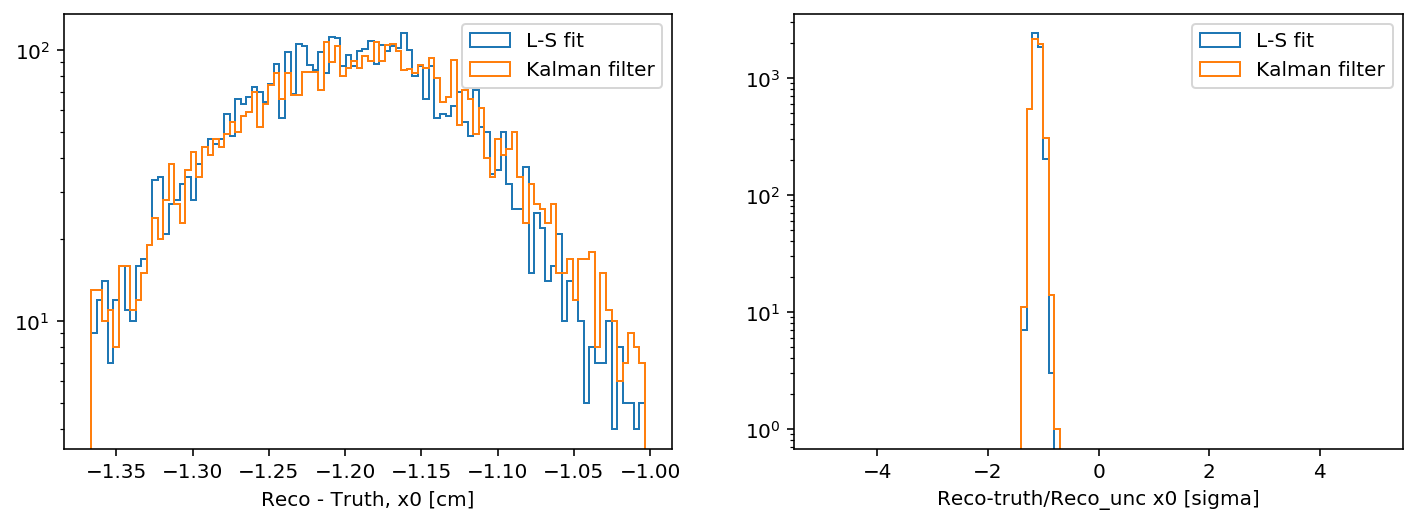

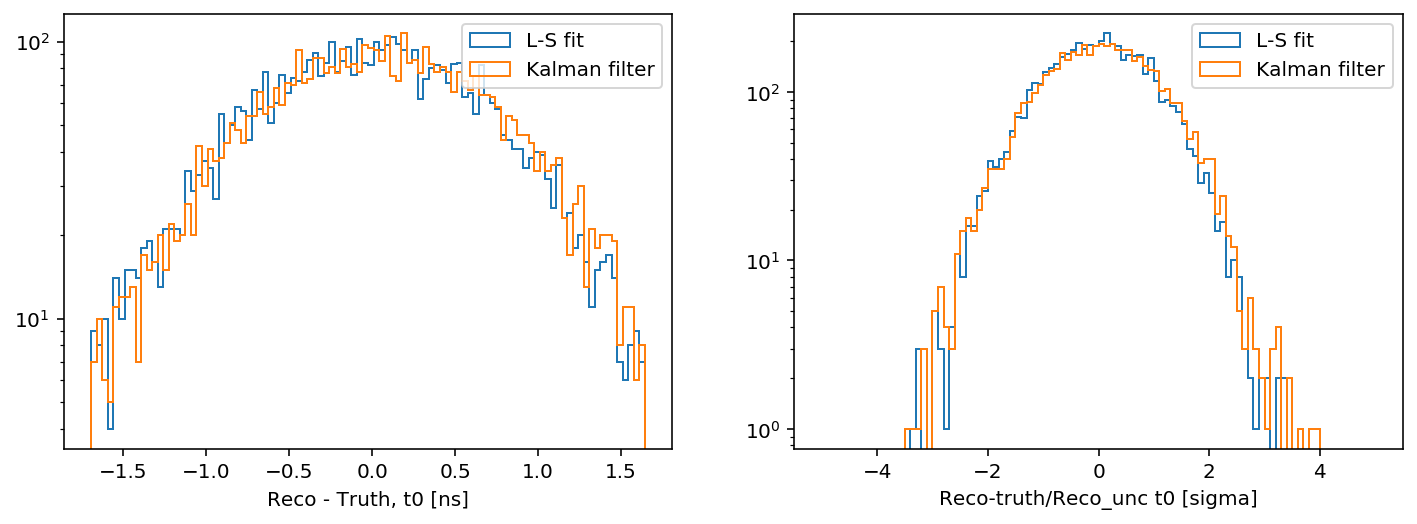

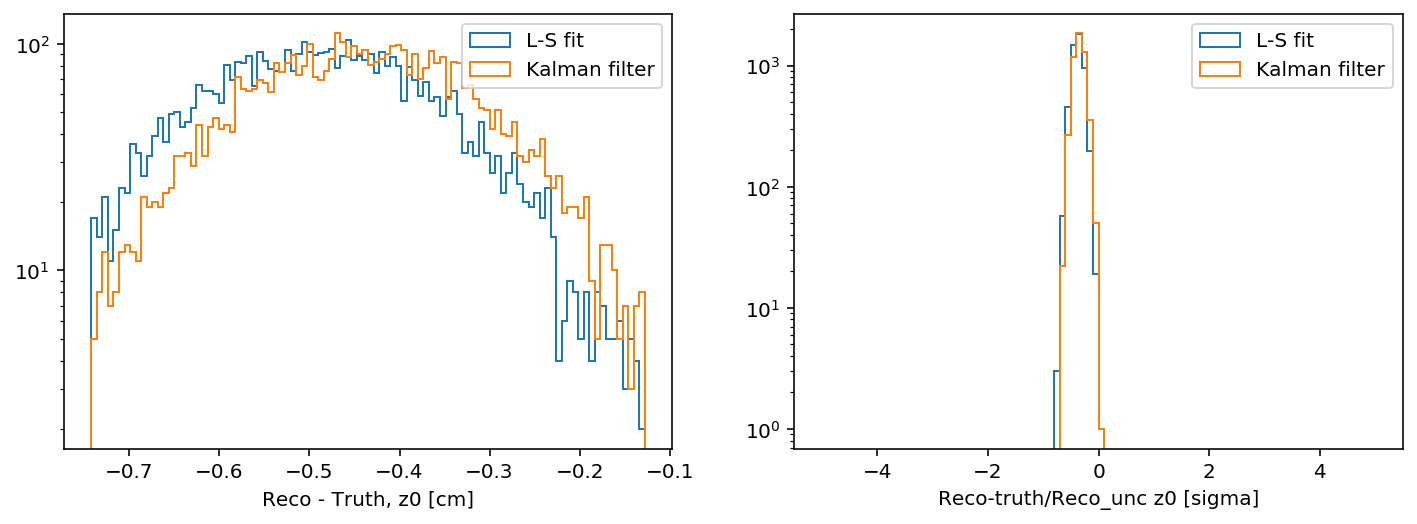

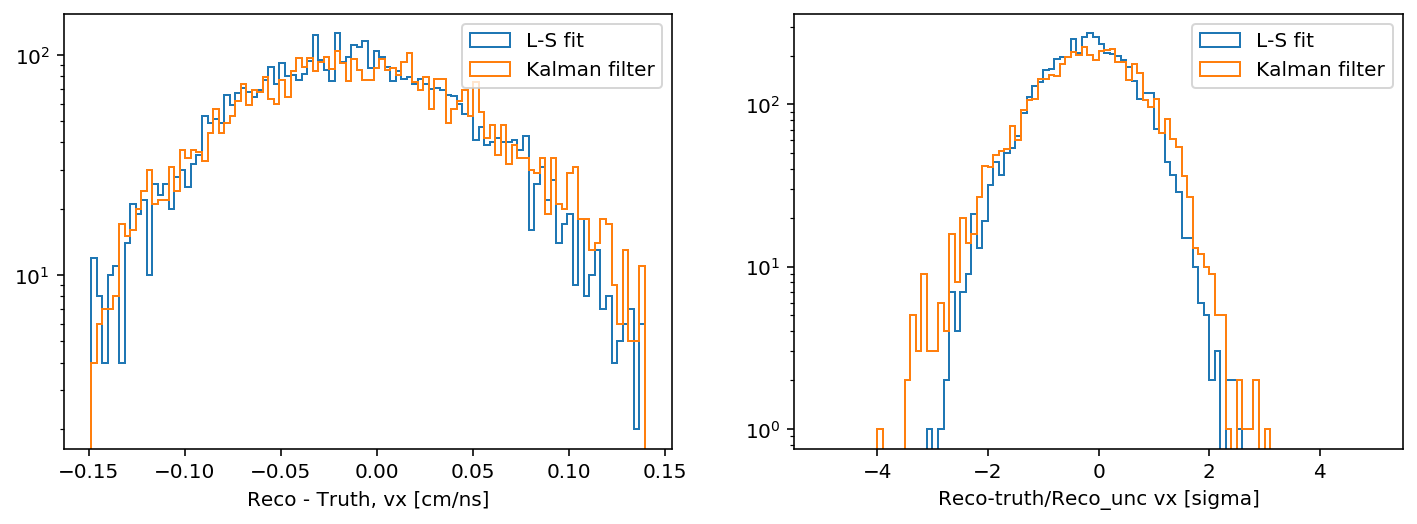

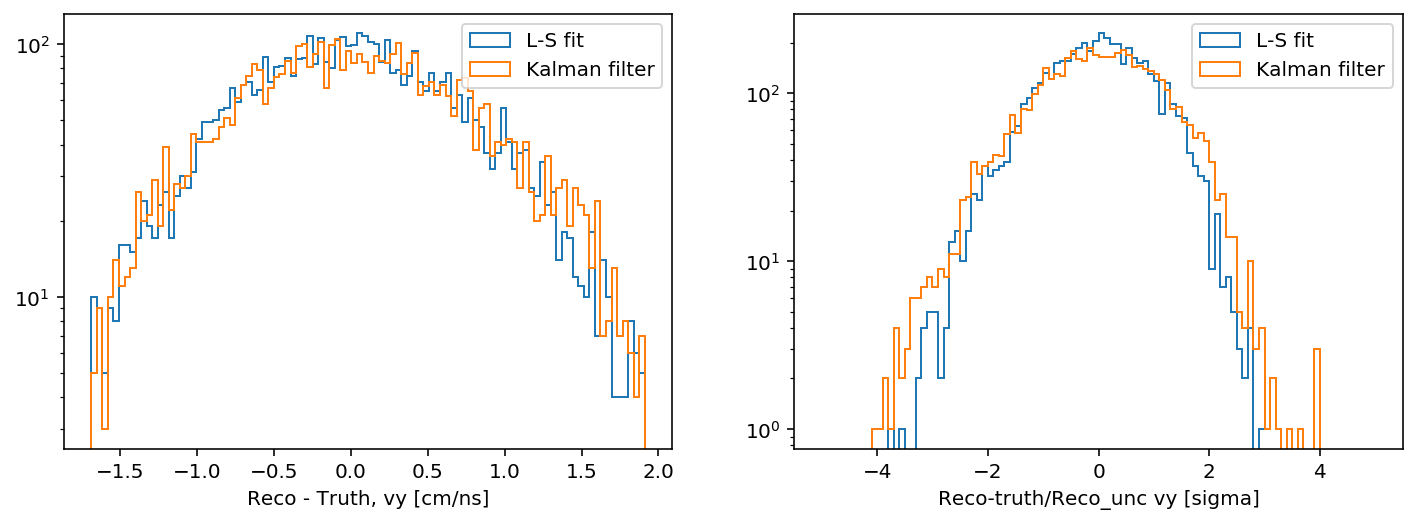

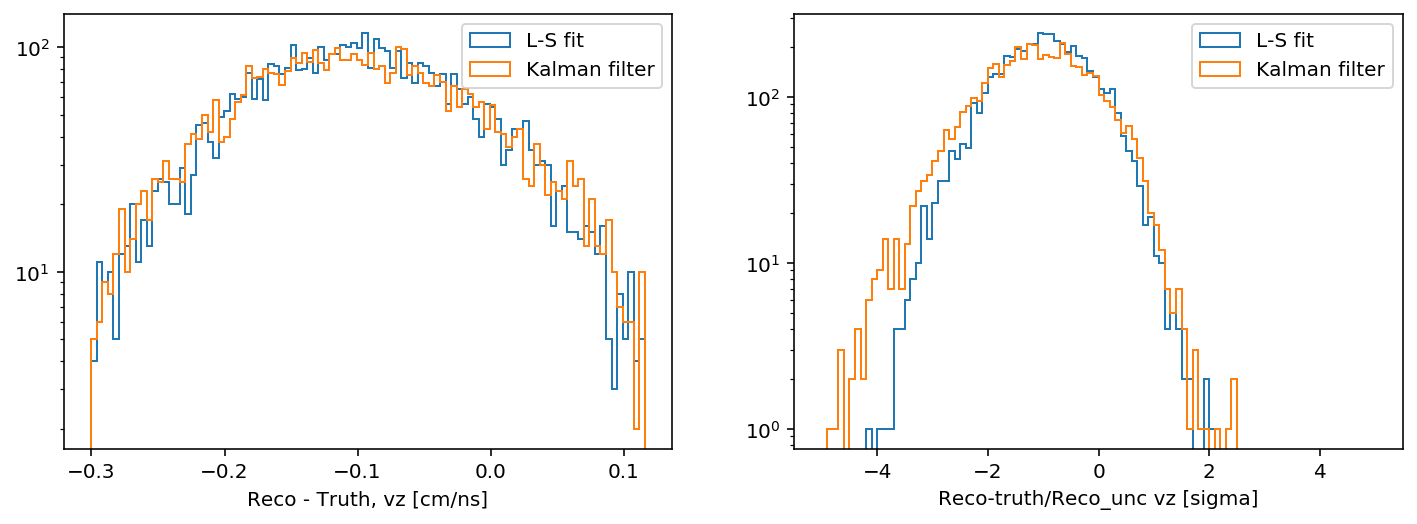

In [28]:
par_names=['x0', 't0','z0',  'vx', 'vy', 'vz'] # Use real world direction
par_unit= ["[cm]",'[ns]',"[cm]","[cm/ns]","[cm/ns]","[cm/ns]"]
# ranges=[(-20,20),(-20,20),(-20,20),(-20,20),(-30,30),(-30,30),(-30,30)]

for ipar in range(6):
    #_range=ranges[ipar]
    residual_ls=results_fit["recon_0"][:,ipar]-results_fit["hits_truth"][:,ipar]
    residual_km=results_fit["recon_1"][:,ipar]-results_fit["hits_truth"][:,ipar]
    _range=(np.percentile(residual_km,1),np.percentile(residual_km,99))
    
    def pull(x_measure, x_truth, x_unc):
        return (x_measure-x_truth)/x_unc
    pull_ls=pull(residual_ls,0,results_fit["recon_0_err"][:,ipar])
    pull_km=pull(residual_km,0,results_fit["recon_1_err"][:,ipar])
    
    fig,axs=plt.subplots(1,2,figsize=(12,4))
    plt.sca(axs[0])
    plt.hist(residual_ls,histtype="step",bins=100,range=_range,label="L-S fit");#bins=np.linspace(360,500,100));
    plt.hist(residual_km,histtype="step",bins=100,range=_range,label="Kalman filter");#bins=np.linspace(360,500,100));
    plt.legend()
    plt.xlabel(f"Reco - Truth, {par_names[ipar]} {par_unit[ipar]}")
    plt.yscale("log")
    plt.sca(axs[1])
    plt.hist(pull_ls,histtype="step",bins=100,range=(-5,5),label="L-S fit");#bins=np.linspace(360,500,100));
    plt.hist(pull_km,histtype="step",bins=100,range=(-5,5),label="Kalman filter");#bins=np.linspace(360,500,100));
    plt.legend()
    plt.xlabel(f"Reco-truth/Reco_unc {par_names[ipar]} [sigma]")
    plt.yscale("log")    
    
    
    plt.show()

In [ ]:
    A << 1.0, .0, .0, dy / x_hat[4], -dy* x_hat[3]/(x_hat[4] * x_hat[4]), .0,
      .0, 1.0, .0, .0, -dy / (x_hat[4] * x_hat[4]), .0,
      .0, .0, 1.0, .0, -dy* x_hat[5]/(x_hat[4] * x_hat[4]), dy / x_hat[4],
      .0, .0, .0, 1.0, .0, .0,
      .0, .0, .0, .0, 1.0, .0,
      .0, .0, .0, .0, .0, 1.0;